# 0. Prep: install libraries and import

In [35]:
!pip install quandl

In [36]:
!pip install yfinance

In [37]:
import quandl
import pandas_datareader as pdr

import pandas as pd
import yfinance as yf
import numpy as np

from datetime import date

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import copy

In [38]:
from tqdm import tqdm

# 1. Get Data from Datasources (FRED, QUANDL, STOOQ)

In [39]:
# Macro economic indicators (mostly US) from the FRED database
# Detailed info on each indicator check on web: https://fred.stlouisfed.org/series/<indicator_name>

FRED_INDICATORS = ['GDP', 'GDPC1', 'GDPPOT', 'NYGDPMKTPCDWLD',         # 1. Growth
                   'CPIAUCSL', 'CPILFESL', 'GDPDEF',                   # 2. Prices and Inflation
                   'M1SL', 'WM1NS', 'WM2NS', 'M1V', 'M2V', 'WALCL',    # 3. Money Supply
                   'DFF', 'DTB3', 'DGS5', 'DGS10', 'DGS30', 'T5YIE',   # 4. Interest Rates
                   'T10YIE', 'T5YIFR', 'TEDRATE', 'DPRIME',            # 4. Interest Rates
                   'UNRATE', 'NROU', 'CIVPART', 'EMRATIO',             # 5. Employment
                   'UNEMPLOY', 'PAYEMS', 'MANEMP', 'ICSA', 'IC4WSA',   # 5. Employment
                   'CDSP', 'MDSP', 'FODSP', 'DSPIC96', 'PCE', 'PCEDG', # 6. Income and Expenditure
                   'PSAVERT', 'DSPI', 'RSXFS',                         # 6. Income and Expenditure
                   'INDPRO', 'TCU', 'HOUST', 'GPDI', 'CP', 'STLFSI2',  # 7. Other indicators
                   'DCOILWTICO', 'DTWEXAFEGS', 'DTWEXBGS',             # 7. Other indicators
                   'GFDEBTN', 'GFDEGDQ188S',                           # 8. Gov-t debt
                   # 9. Additional indicators from IVAN
                   'DEXUSEU', 'GVZCLS', 'VIXCLS', 'DIVIDEND',
                   # 9. Additional indicators from IVAN
                   'MORTGAGE30US', 'SPCS20RSA'
                   ]

# Macro Indicators from QUANDL
QUANDL_INDICATORS = {'BCHAIN/MKPRU', 'USTREASURY/YIELD', 'USTREASURY/REALYIELD',  # 9. Additional indicators from IVAN
                     # 9. Additional indicators from IVAN
                     'MULTPL/SHILLER_PE_RATIO_MONTH', 'LBMA/GOLD'
                     }

# Stock maret indexes
  # All indexes: https://stooq.com/t/ 
STOOQ_INDICATORS = {'^DJI','^SPX'}  

# update period for each ind (Y=Yearly, Q=Quarterly, M=Monthly, W=Weekly, D=Daily)
INDICATORS_PERIODS = {'GDP': 'Q', 'GDPC1': 'Q', 'GDPPOT': 'Q', 'NYGDPMKTPCDWLD': 'Y',                 # 1. Growth
                      # 2. Prices and Inflation
                      'CPIAUCSL': 'M', 'CPILFESL': 'M', 'GDPDEF': 'Q',
                      # 3. Money Supply
                      'M1SL': 'M', 'WM1NS': 'W', 'WM2NS': 'W', 'M1V': 'Q', 'M2V': 'Q', 'WALCL': 'W',
                      # 4. Interest Rates
                      'DFF': 'D', 'DTB3': 'D', 'DGS5': 'D', 'DGS10': 'D', 'DGS30': 'D', 'T5YIE': 'D',
                      # 4. Interest Rates
                      'T10YIE': 'D', 'T5YIFR': 'D', 'TEDRATE': 'D', 'DPRIME': 'D',
                      # 5. Employment
                      'UNRATE': 'M', 'NROU': 'Q', 'CIVPART': 'M', 'EMRATIO': 'M',
                      # 5. Employment
                      'UNEMPLOY': 'M', 'PAYEMS': 'M', 'MANEMP': 'M', 'ICSA': 'W', 'IC4WSA': 'W',
                      # 6. Income and Expenditure
                      'CDSP': 'Q', 'MDSP': 'Q', 'FODSP': 'Q', 'DSPIC96': 'M', 'PCE': 'M', 'PCEDG': 'M',
                      # 6. Income and Expenditure
                      'PSAVERT': 'M', 'DSPI': 'M', 'RSXFS': 'M',
                      # 7. Other indicators
                      'INDPRO': 'M', 'TCU': 'M', 'HOUST': 'M', 'GPDI': 'Q', 'CP': 'Q', 'STLFSI2': 'W',
                      # 7. Other indicators
                      'DCOILWTICO': 'D', 'DTWEXAFEGS': 'D', 'DTWEXBGS': 'D',
                      # 8. Gov-t debt
                      'GFDEBTN': 'Q', 'GFDEGDQ188S': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'DEXUSEU': 'D', 'GVZCLS': 'D', 'VIXCLS': 'D', 'DIVIDEND': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'MORTGAGE30US': 'W', 'SPCS20RSA': 'M',
                      # 9.QUANDL: Additional indicators from IVAN
                      'BCHAIN_MKPRU': 'D', 'USTREASURY_YIELD': 'D', 'USTREASURY_REALYIELD': 'D',
                      'MULTPL_SHILLER_PE_RATIO_MONTH': 'M', 'LBMA_GOLD': 'D',
                      # 10. INDEXES
                      'SPX': 'D', 'DJI': 'D'
                      }

In [40]:
end = date.today()
start = date(year=end.year-35, month=end.month, day=end.day)
macro_indicators = dict()
tq_fred = tqdm(FRED_INDICATORS)

# get the stats from FRED database (with Pandas Datareader API)
tq_fred.set_description('Downloading stats from FRED:')
for indicator in tq_fred:
  # tq_fred.set_description(indicator)
  # macro_indicators[indicator] = pdr.DataReader(indicator, "fred", start=start, timeout=90)
  macro_indicators[indicator] = pdr.fred.FredReader(indicator, start=start, timeout=90).read()

In [41]:
macro_indicators['GDP']

GDP
DATE                 
1987-07-01   4884.555
1987-10-01   5007.994
1988-01-01   5073.372
1988-04-01   5190.036
1988-07-01   5282.835
...               ...
2021-01-01  22038.226
2021-04-01  22740.959
2021-07-01  23202.344
2021-10-01  24002.815
2022-01-01  24382.683

[139 rows x 1 columns]

In [42]:
tq_quandl = tqdm(QUANDL_INDICATORS)
# get the stats from QUANDL database
tq_quandl.set_description("Downloading stats from QUANDL:")
for indicator in tq_quandl:
 # tq_quandl.set_description(indicator)
 # modify all indicator names '/': like "USTREASURY/YIELD" to "USTREASURY_YIELD"
 macro_indicators[indicator.replace("/", "_")] = quandl.get(indicator, start_date=start, end_date=end, authtoken="5qE7KbLemDiZ9RfNsVuM")

In [43]:
for indicator in tqdm(STOOQ_INDICATORS):
  macro_indicators[indicator.replace("^", "")]= pdr.get_data_stooq(indicator, start, end)

100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


In [44]:
for i,value in enumerate(macro_indicators.keys()):
  if i%6==0:
    print('\n')
  print(value, end =", ")  



GDP, GDPC1, GDPPOT, NYGDPMKTPCDWLD, CPIAUCSL, CPILFESL, 

GDPDEF, M1SL, WM1NS, WM2NS, M1V, M2V, 

WALCL, DFF, DTB3, DGS5, DGS10, DGS30, 

T5YIE, T10YIE, T5YIFR, TEDRATE, DPRIME, UNRATE, 

NROU, CIVPART, EMRATIO, UNEMPLOY, PAYEMS, MANEMP, 

ICSA, IC4WSA, CDSP, MDSP, FODSP, DSPIC96, 

PCE, PCEDG, PSAVERT, DSPI, RSXFS, INDPRO, 

TCU, HOUST, GPDI, CP, STLFSI2, DCOILWTICO, 

DTWEXAFEGS, DTWEXBGS, GFDEBTN, GFDEGDQ188S, DEXUSEU, GVZCLS, 

VIXCLS, DIVIDEND, MORTGAGE30US, SPCS20RSA, BCHAIN_MKPRU, MULTPL_SHILLER_PE_RATIO_MONTH, 

USTREASURY_YIELD, USTREASURY_REALYIELD, LBMA_GOLD, SPX, DJI, 

In [45]:
macro_indicators['GDP']

GDP
DATE                 
1987-07-01   4884.555
1987-10-01   5007.994
1988-01-01   5073.372
1988-04-01   5190.036
1988-07-01   5282.835
...               ...
2021-01-01  22038.226
2021-04-01  22740.959
2021-07-01  23202.344
2021-10-01  24002.815
2022-01-01  24382.683

[139 rows x 1 columns]

In [46]:
# ORIGINAL STATS (need to reverse SPX and DJI):

macro_indicators['SPX'].tail()

Open    High     Low   Close     Volume
Date                                                 
1987-05-15  294.23  294.24  287.11  287.43  100444444
1987-05-14  293.98  295.10  292.95  294.24   84444444
1987-05-13  293.31  294.54  290.74  293.98   95000000
1987-05-12  291.57  293.30  290.18  293.30   86277778
1987-05-11  293.37  298.69  291.55  291.57  113166667

In [47]:
macro_indicators['SPX'] = macro_indicators['SPX'].reindex(index=macro_indicators['SPX'].index[::-1])
macro_indicators['DJI'] = macro_indicators['DJI'].reindex(index=macro_indicators['DJI'].index[::-1])

In [48]:
macro_indicators['SPX'].tail()

Open     High      Low    Close      Volume
Date                                                      
2022-05-02  4130.61  4169.81  4062.51  4155.38  2741101346
2022-05-03  4159.78  4200.10  4147.08  4175.48  2504555235
2022-05-04  4181.18  4307.66  4148.91  4300.17  2875234248
2022-05-05  4270.43  4270.43  4106.01  4146.87  2869945993
2022-05-06  4128.17  4157.69  4067.91  4123.34  2737777030

<AxesSubplot:title={'center':'S&P500 Stock index'}, xlabel='Date'>

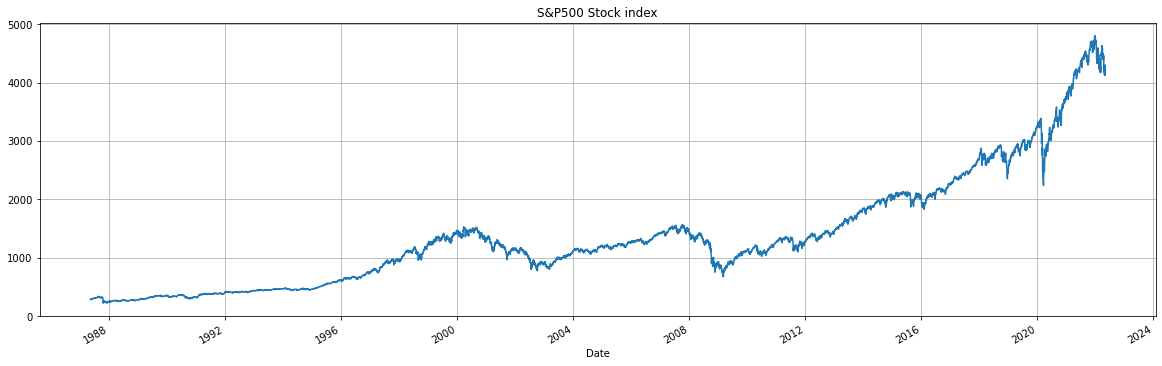

In [49]:
macro_indicators['SPX']['Close'].plot.line(figsize=(20,6), grid = True, title='S&P500 Stock index')

<AxesSubplot:title={'center':'DJI Stock index'}, xlabel='Date'>

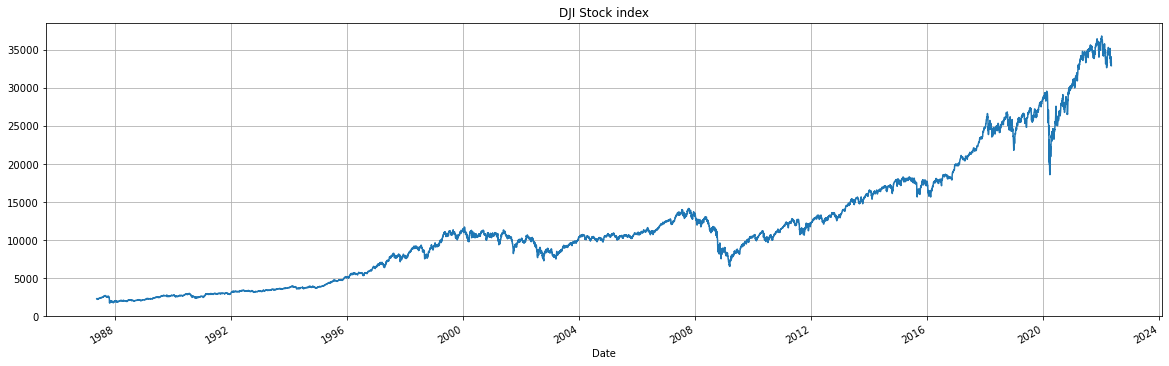

In [50]:
macro_indicators['DJI']['Close'].plot.line(figsize=(20,6), grid = True, title='DJI Stock index')

<AxesSubplot:title={'center':'CBOE Gold ETF Volatility Index (GVZCLS) - daily'}, xlabel='DATE'>

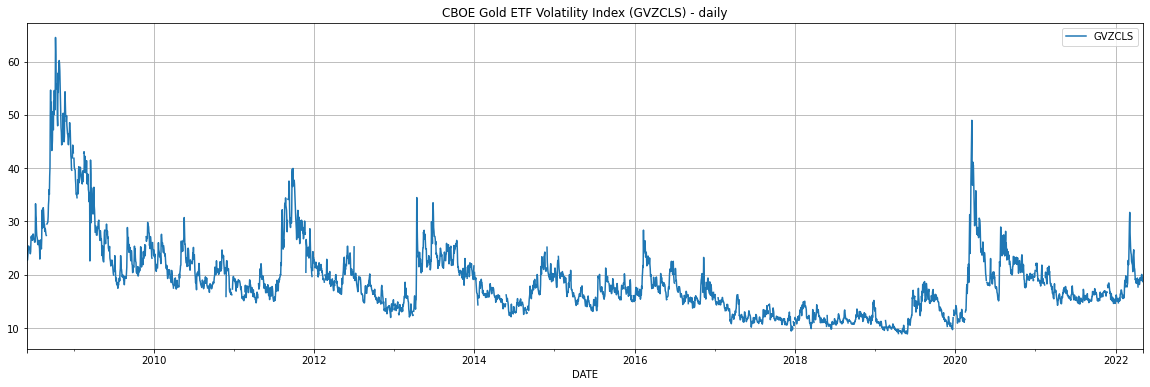

In [51]:
# https://fred.stlouisfed.org/series/GVZCLS
macro_indicators['GVZCLS'].plot.line(figsize=(20,6), grid = True, title='CBOE Gold ETF Volatility Index (GVZCLS) - daily')

<AxesSubplot:title={'center':' CBOE Volatility Index: VIX (VIXCLS)\t - daily'}, xlabel='DATE'>

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


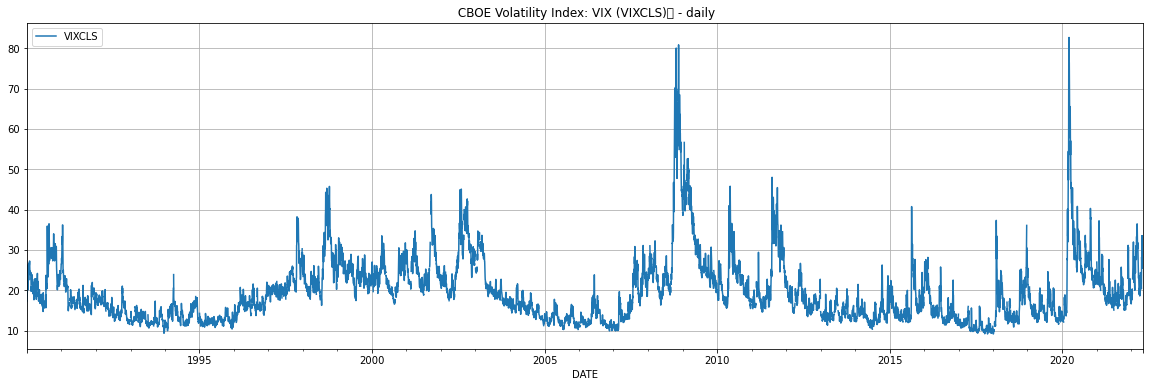

In [52]:
# https://fred.stlouisfed.org/series/VIXCLS
macro_indicators['VIXCLS'].plot.line(figsize=(20,6), grid = True, title=' CBOE Volatility Index: VIX (VIXCLS)	 - daily')

<AxesSubplot:title={'center':'St. Louis Fed Financial Stress Index (STLFSI2) - daily'}, xlabel='DATE'>

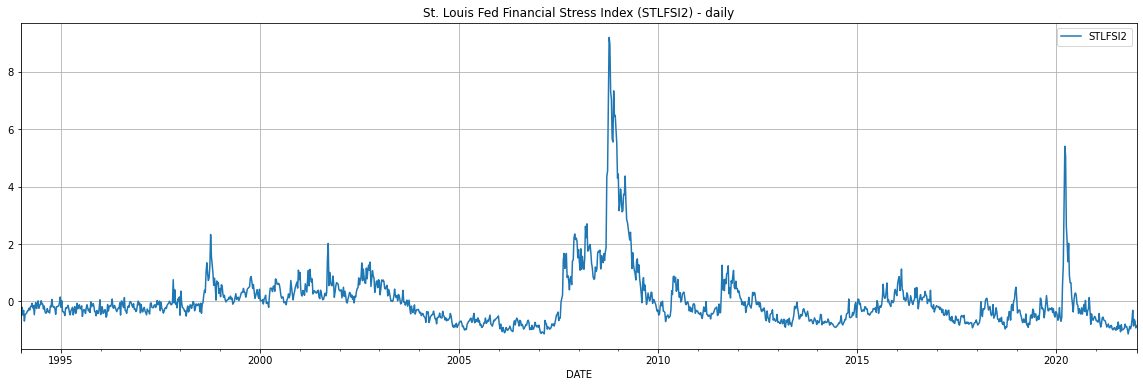

In [53]:
# https://fred.stlouisfed.org/series/STLFSI2
macro_indicators['STLFSI2'].plot.line(figsize=(20,6), grid = True, title='St. Louis Fed Financial Stress Index (STLFSI2) - daily')

<AxesSubplot:title={'center':' Household Financial Obligations as a Percent of Disposable Personal Income (FODSP) - Quarterly'}, xlabel='DATE'>

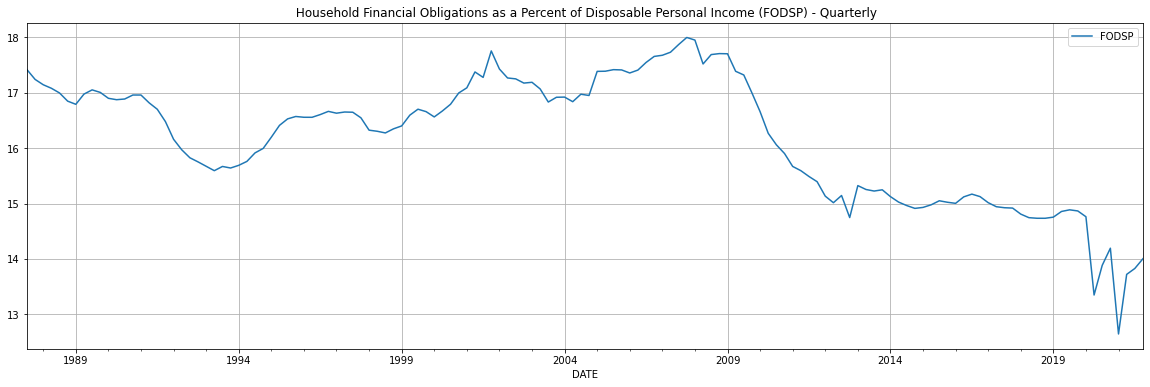

In [54]:
# https://fred.stlouisfed.org/series/FODSP
macro_indicators['FODSP'].plot.line(figsize=(20,6), grid = True, title=' Household Financial Obligations as a Percent of Disposable Personal Income (FODSP) - Quarterly')

<AxesSubplot:title={'center':'Shiller PE Ratio - Monthly'}, xlabel='Date'>

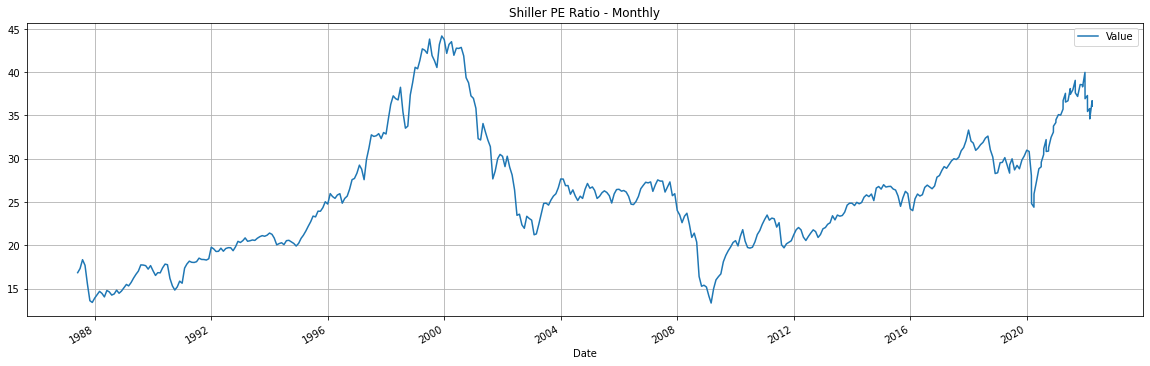

In [55]:
# https://www.multpl.com/shiller-pe
# https://data.nasdaq.com/data/MULTPL/SHILLER_PE_RATIO_MONTH-shiller-pe-ratio-by-month
macro_indicators['MULTPL_SHILLER_PE_RATIO_MONTH'].plot.line(figsize=(20,6), grid = True, title='Shiller PE Ratio - Monthly')

<AxesSubplot:title={'center':'All Employees, Manufacturing (MANEMP) - Monthly'}, xlabel='DATE'>

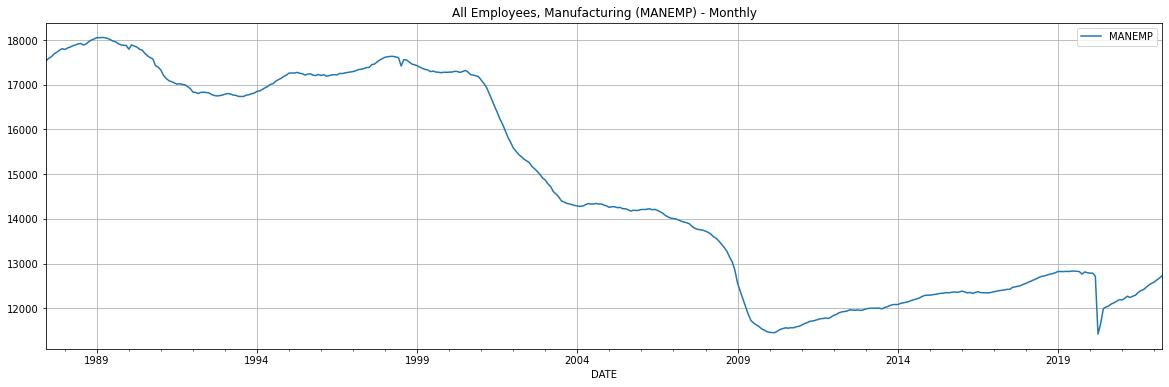

In [56]:
# https://fred.stlouisfed.org/series/MANEMP
macro_indicators['MANEMP'].plot.line(figsize=(20,6), grid = True, title='All Employees, Manufacturing (MANEMP) - Monthly')

In [57]:
macro_indicators.keys()

dict_keys(['GDP', 'GDPC1', 'GDPPOT', 'NYGDPMKTPCDWLD', 'CPIAUCSL', 'CPILFESL', 'GDPDEF', 'M1SL', 'WM1NS', 'WM2NS', 'M1V', 'M2V', 'WALCL', 'DFF', 'DTB3', 'DGS5', 'DGS10', 'DGS30', 'T5YIE', 'T10YIE', 'T5YIFR', 'TEDRATE', 'DPRIME', 'UNRATE', 'NROU', 'CIVPART', 'EMRATIO', 'UNEMPLOY', 'PAYEMS', 'MANEMP', 'ICSA', 'IC4WSA', 'CDSP', 'MDSP', 'FODSP', 'DSPIC96', 'PCE', 'PCEDG', 'PSAVERT', 'DSPI', 'RSXFS', 'INDPRO', 'TCU', 'HOUST', 'GPDI', 'CP', 'STLFSI2', 'DCOILWTICO', 'DTWEXAFEGS', 'DTWEXBGS', 'GFDEBTN', 'GFDEGDQ188S', 'DEXUSEU', 'GVZCLS', 'VIXCLS', 'DIVIDEND', 'MORTGAGE30US', 'SPCS20RSA', 'BCHAIN_MKPRU', 'MULTPL_SHILLER_PE_RATIO_MONTH', 'USTREASURY_YIELD', 'USTREASURY_REALYIELD', 'LBMA_GOLD', 'SPX', 'DJI'])

In [58]:
# Total indicators from FRED, QUANDL, and STOOQ:
len(macro_indicators.keys())

65

# 2) Add transformations: DoD, WoW, MoM, YoY growth

In [59]:
# need to have a deep copy of macro indicators to make local transformations not changing the datarepo
macro_indicators_dict = copy.deepcopy(macro_indicators)

In [60]:
def get_macro_shift_transformation(macro_indicators_dict):
        """Add shifted (growth) values to the data_repo.macro_indicators before joining them together, remove non-stationary time series"""
        
        # Transform daily stats on this shift
        HISTORICAL_PERIODS_DAYS = [1, 3, 7, 30, 90, 365]
        
        # Different types of transformations for daily, weekly, monthly, indicators
        DoD_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'D']
        WoW_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'W']
        MoM_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'M']
        QoQ_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Q']
        YoY_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Y']

        # rename and drop some columns (especially from QUANDL)
        macro_indicators_dict['BCHAIN_MKPRU'].rename(
            columns={'Value': 'BCHAIN_MKPRU'}, inplace=True)
        macro_indicators_dict['MULTPL_SHILLER_PE_RATIO_MONTH'].rename(
            columns={'Value': 'MULTPL_SHILLER_PE_RATIO_MONTH'}, inplace=True)
        #  GOLD PRICE == evening (PM) value in USD on London Stock Exchange, drop all other columns
        macro_indicators_dict['LBMA_GOLD'].rename(
            columns={'USD (PM)': 'LBMA_GOLD'}, inplace=True)
        macro_indicators_dict['LBMA_GOLD'].drop(
            ['USD (AM)', 'GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)'], axis=1, inplace=True)
        
        # INDEXES: leave only Close price
        macro_indicators_dict['SPX'].drop(
            ['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
        macro_indicators_dict['SPX'].rename(
            columns={'Close': 'SPX'}, inplace=True)
        macro_indicators_dict['DJI'].drop(
            ['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
        macro_indicators_dict['DJI'].rename(
            columns={'Close': 'DJI'}, inplace=True)

        for ind in DoD_ind:
            # do transform only if oil_prices, blockchain_prices, gold_prices, indexes
            if not ind in {'DCOILWTICO', 'BCHAIN_MKPRU', 'LBMA_GOLD','SPX','DJI'}:
                continue
            # treat those as an index
            for i in HISTORICAL_PERIODS_DAYS:
                df = macro_indicators_dict[ind]
                ind_transformed = ind + '_growth_' + str(i)+'d'
                df[ind_transformed] = df[ind]/df[ind].shift(i)-1

        # future growth stats
        for ind in ['SPX','DJI']:
          for i in HISTORICAL_PERIODS_DAYS:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_future_growth_' + str(i)+'d'
            df[ind_transformed] = df[ind].shift(-i-1)/df[ind].shift(-1)-1

        for ind in WoW_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_wow'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(5)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for FinStressIndex (STLFSI2), and Long-term Mortgage rates
            if not ind in {'STLFSI2', 'MORTGAGE30US'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        for ind in MoM_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(12)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for all indicators that are 'ratios' or 'percentages'
            if not ind in {'UNRATE', 'CIVPART', 'EMRATIO', 'PSAVERT', 'INDPRO', 'TCU', 'SPCS20RSA', 'MULTPL_SHILLER_PE_RATIO_MONTH'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        # create one field as div_ratio (% of profits paid as dividents)
        macro_indicators_dict['CP'] = macro_indicators_dict['CP'].join(
            macro_indicators_dict['DIVIDEND'])
        macro_indicators_dict['CP']['div_ratio'] = macro_indicators_dict['CP']['DIVIDEND'] / \
            macro_indicators_dict['CP']['CP']
        macro_indicators_dict['CP'].drop(
            ['DIVIDEND'], axis=1, inplace=True)

        for ind in QoQ_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_qoq'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(4)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for all indicators that are 'ratios' or 'percentages'
            if not ind in {'GDPDEF', 'M1V', 'M2V', 'NROU', 'CDSP', 'MDSP', 'FODSP', 'GFDEGDQ188S'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        for ind in YoY_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            macro_indicators_dict[ind].drop([ind], axis=1, inplace=True)

In [61]:
get_macro_shift_transformation(macro_indicators_dict)

In [62]:
# Daily
macro_indicators_dict['LBMA_GOLD'].tail(1)

LBMA_GOLD  LBMA_GOLD_growth_1d  LBMA_GOLD_growth_3d  \
Date                                                              
2022-05-05     1892.3             0.015373            -0.009941   

            LBMA_GOLD_growth_7d  LBMA_GOLD_growth_30d  LBMA_GOLD_growth_90d  \
Date                                                                          
2022-05-05            -0.001425             -0.022092                0.0555   

            LBMA_GOLD_growth_365d  
Date                               
2022-05-05                0.00885

In [63]:
macro_indicators_dict['SPX'].tail(5)

SPX  SPX_growth_1d  SPX_growth_3d  SPX_growth_7d  \
Date                                                               
2022-05-02  4155.38       0.005675      -0.006831      -0.054233   
2022-05-03  4175.48       0.004837      -0.026127      -0.022543   
2022-05-04  4300.17       0.029862       0.040717       0.000943   
2022-05-05  4146.87      -0.035650      -0.002048      -0.006785   
2022-05-06  4123.34      -0.005674      -0.012487      -0.014489   

            SPX_growth_30d  SPX_growth_90d  SPX_growth_365d  \
Date                                                          
2022-05-02       -0.068952       -0.106222         0.151225   
2022-05-03       -0.064041       -0.110949         0.170327   
2022-05-04       -0.046866       -0.090063         0.200538   
2022-05-05       -0.069424       -0.134480         0.165657   
2022-05-06       -0.087789       -0.138521         0.152547   

            SPX_future_growth_1d  SPX_future_growth_3d  SPX_future_growth_7d  \
Date                                                                           
2022-05-02              0.029862             -0.012487                   NaN   
2022-05-03             -0.035650                   NaN                   NaN   
2022-05-04             -0.005674                   NaN                   NaN   
2022-05-05                   NaN                   NaN                   NaN   
2022-05-06                   NaN                   NaN                   NaN   

            SPX_future_growth_30d  SPX_future_growth_90d  \
Date                                                       
2022-05-02                    NaN                    NaN   
2022-05-03                    NaN                    NaN   
2022-05-04                    NaN                    NaN   
2022-05-05                    NaN                    NaN   
2022-05-06                    NaN                    NaN   

            SPX_future_growth_365d  
Date                                
2022-05-02                     NaN  
2022-05-03                     NaN  
2022-05-04                     NaN  
2022-05-05                     NaN  
2022-05-06                     NaN

<AxesSubplot:xlabel='Date'>

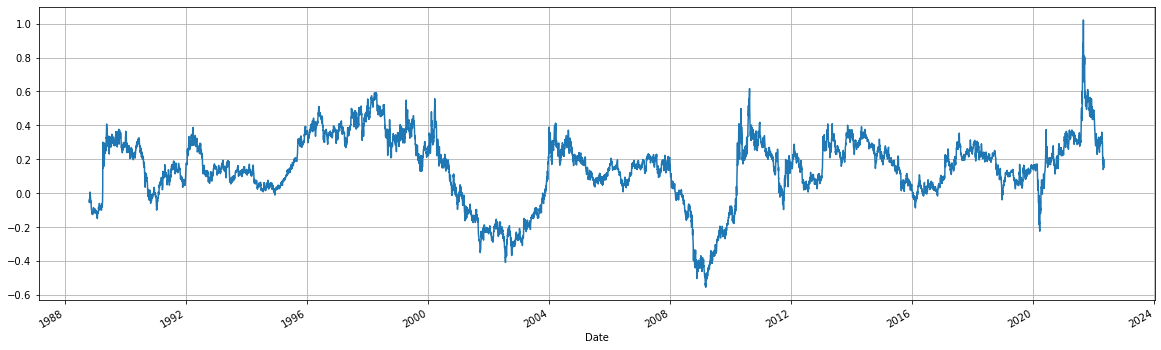

In [64]:
macro_indicators_dict['SPX']['SPX_growth_365d'].plot.line(figsize=(20,6), grid = True)

<AxesSubplot:xlabel='Date'>

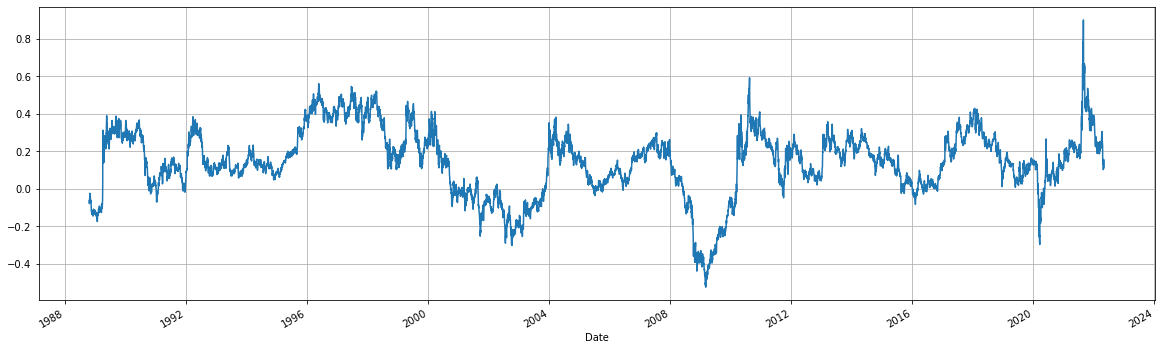

In [65]:
macro_indicators_dict['DJI']['DJI_growth_365d'].plot.line(figsize=(20,6), grid = True)

In [66]:
# Quarterly
macro_indicators_dict['GDP'].tail(5)

GDP_qoq   GDP_yoy
DATE                          
2021-01-01  0.026103  0.025923
2021-04-01  0.031887  0.167554
2021-07-01  0.020289  0.097631
2021-10-01  0.034500  0.117575
2022-01-01  0.015826  0.106381

In [67]:
# Monthly
macro_indicators_dict['CPILFESL'].tail(5)

CPILFESL_mom  CPILFESL_yoy
DATE                                  
2021-11-01      0.005232      0.049526
2021-12-01      0.005618      0.054766
2022-01-01      0.005833      0.060408
2022-02-01      0.005052      0.064157
2022-03-01      0.003241      0.064360

In [68]:
# Weekly
macro_indicators_dict['ICSA'].tail(5)

ICSA_wow  ICSA_mom
DATE                          
2022-04-02 -0.017544 -0.076923
2022-04-09  0.107143 -0.060606
2022-04-16 -0.005376  0.045198
2022-04-23 -0.021622  0.090361
2022-04-30  0.104972  0.169591

In [69]:
# Yearly (WORLD GDP)
macro_indicators_dict['NYGDPMKTPCDWLD'].tail(1)

NYGDPMKTPCDWLD_yoy
DATE                          
2020-01-01           -0.032216

In [70]:
for i,value in enumerate(macro_indicators_dict.keys()):
  if i%6==0:
    print('\n')
  print(value, end =", ")  



GDP, GDPC1, GDPPOT, NYGDPMKTPCDWLD, CPIAUCSL, CPILFESL, 

GDPDEF, M1SL, WM1NS, WM2NS, M1V, M2V, 

WALCL, DFF, DTB3, DGS5, DGS10, DGS30, 

T5YIE, T10YIE, T5YIFR, TEDRATE, DPRIME, UNRATE, 

NROU, CIVPART, EMRATIO, UNEMPLOY, PAYEMS, MANEMP, 

ICSA, IC4WSA, CDSP, MDSP, FODSP, DSPIC96, 

PCE, PCEDG, PSAVERT, DSPI, RSXFS, INDPRO, 

TCU, HOUST, GPDI, CP, STLFSI2, DCOILWTICO, 

DTWEXAFEGS, DTWEXBGS, GFDEBTN, GFDEGDQ188S, DEXUSEU, GVZCLS, 

VIXCLS, DIVIDEND, MORTGAGE30US, SPCS20RSA, BCHAIN_MKPRU, MULTPL_SHILLER_PE_RATIO_MONTH, 

USTREASURY_YIELD, USTREASURY_REALYIELD, LBMA_GOLD, SPX, DJI, 

# 3) Smart join to one dataframe (D,W,M,Q,Y - sources)

In [71]:
dates = pd.DataFrame(macro_indicators_dict['SPX'].index.sort_values().unique(), columns=['Date'])
dates

Date
0    1987-05-11
1    1987-05-12
2    1987-05-13
3    1987-05-14
4    1987-05-15
...         ...
8815 2022-05-02
8816 2022-05-03
8817 2022-05-04
8818 2022-05-05
8819 2022-05-06

[8820 rows x 1 columns]

In [72]:
def get_daily_macro_stats_df(daily_df, macro_ind_df, regime='LAST'):
        """take Time from daily_df, and apply that to macro_ind_df, (LAST=take last observation, PREVIOUS=take previous) """
        ticker_dates = daily_df.Date.sort_values().unique()
        new_column_dict = {}

        for elem in ticker_dates:
            ts = pd.to_datetime(str(elem))
            d = ts.strftime('%Y-%m-%d')
            # all potential records to merge
            options_to_merge = macro_ind_df[macro_ind_df.index <= d]
            if len(options_to_merge) == 0:
                continue
            last_value = options_to_merge.tail(1).values.tolist()[0]
            prev_value = options_to_merge.tail(2).values.tolist()[0]
            if regime == 'PREVIOUS':
                if prev_value is not None:
                    new_column_dict[d] = prev_value
            elif regime == 'LAST':
                if last_value is not None:
                    new_column_dict[d] = last_value
            else:
                raise("Regime should be in ('PREVIOUS','LAST')")
        return pd.DataFrame.from_dict(new_column_dict, orient='index', columns = options_to_merge.keys())

In [73]:
# 2) Create a DAILY macro stats dataset
# Different types of joins for daily, weekly, monthly, indicators
  # join on the last available date
lastday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v not in ('M', 'Q', 'Y')]
  # join on the previous available date (M,Q,Y stats write say '2021-01-01' - but they represent the whole M,Q,Y STARTING at this date)
firstday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v in ('M', 'Q', 'Y')]

  # start from all dates we need to have macro stats
dates = pd.DataFrame(macro_indicators_dict['SPX'].index.sort_values().unique(), columns=['Date'])

macro_data_df = None
#  iterate over all transformed series in self.macro_indicators_dict and join one by one
# all non-Monthly indicators are
tq_last_day = tqdm(lastday_ind)
tq_last_day.set_description("Merging LAST Day indicators")
for ind in tq_last_day:
  # do not add some indicators to the final dataset (they are duplicated in another datasource)
  if ind in ('USTREASURY_YIELD', 'USTREASURY_REALYIELD'):
    continue
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='LAST')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

tq_first_day = tqdm(firstday_ind)
tq_first_day.set_description("Merging FIRST Day indicators")
#  some stats  have first day of period date (e.g. '2020-06-01' instead of '2020-06-30'), so we need to get PREVIOUS available macro param
for ind in tq_first_day:
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='PREVIOUS')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

Merging FIRST Day indicators: 100%|██████████| 36/36 [02:24<00:00,  4.00s/it]


In [74]:
macro_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8820 entries, 1987-05-11 to 2022-05-06
Columns: 166 entries, WM1NS_wow to MULTPL_SHILLER_PE_RATIO_MONTH_yoy
dtypes: float64(166)
memory usage: 11.5+ MB


In [76]:
# learn how to save a dataframe efficiently
macro_data_df.to_parquet('macro_df_small.parquet',compression='BROTLI')

In [77]:
macro_df = pd.read_parquet('macro_df_small.parquet')

In [78]:
len(macro_df.keys())

166

In [79]:
i=1
for value in macro_df.keys():
  if not ('future' in value):
    print(value, end =", ")
    if i%8==0:
      print('\n')
    i+=1
    

WM1NS_wow, WM1NS_mom, WM2NS_wow, WM2NS_mom, WALCL_wow, WALCL_mom, DFF, DTB3, 

DGS5, DGS10, DGS30, T5YIE, T10YIE, T5YIFR, TEDRATE, DPRIME, 

ICSA_wow, ICSA_mom, IC4WSA_wow, IC4WSA_mom, STLFSI2, STLFSI2_wow, STLFSI2_mom, DCOILWTICO, 

DCOILWTICO_growth_1d, DCOILWTICO_growth_3d, DCOILWTICO_growth_7d, DCOILWTICO_growth_30d, DCOILWTICO_growth_90d, DCOILWTICO_growth_365d, DTWEXAFEGS, DTWEXBGS, 

DEXUSEU, GVZCLS, VIXCLS, MORTGAGE30US, MORTGAGE30US_wow, MORTGAGE30US_mom, BCHAIN_MKPRU, BCHAIN_MKPRU_growth_1d, 

BCHAIN_MKPRU_growth_3d, BCHAIN_MKPRU_growth_7d, BCHAIN_MKPRU_growth_30d, BCHAIN_MKPRU_growth_90d, BCHAIN_MKPRU_growth_365d, LBMA_GOLD, LBMA_GOLD_growth_1d, LBMA_GOLD_growth_3d, 

LBMA_GOLD_growth_7d, LBMA_GOLD_growth_30d, LBMA_GOLD_growth_90d, LBMA_GOLD_growth_365d, SPX, SPX_growth_1d, SPX_growth_3d, SPX_growth_7d, 

SPX_growth_30d, SPX_growth_90d, SPX_growth_365d, DJI, DJI_growth_1d, DJI_growth_3d, DJI_growth_7d, DJI_growth_30d, 

DJI_growth_90d, DJI_growth_365d, GDP_qoq, GDP_yoy, GDPC

In [80]:
pd.set_option('display.max_columns', 10)
macro_df.tail(1)
# pd.set_option('display.max_columns', None)

WM1NS_wow  WM1NS_mom  WM2NS_wow  WM2NS_mom  WALCL_wow  ...  \
2022-05-06   0.006863   0.016334   0.006691   0.016604   0.000086  ...   

            SPCS20RSA_mom  SPCS20RSA_yoy  MULTPL_SHILLER_PE_RATIO_MONTH  \
2022-05-06       0.017085        0.18934                          36.71   

            MULTPL_SHILLER_PE_RATIO_MONTH_mom  \
2022-05-06                           0.060676   

            MULTPL_SHILLER_PE_RATIO_MONTH_yoy  
2022-05-06                          -0.024189  

[1 rows x 166 columns]

In [81]:
macro_df.tail(100)

WM1NS_wow  WM1NS_mom  WM2NS_wow  WM2NS_mom  WALCL_wow  ...  \
2021-12-14   0.002477   0.016605   0.002630   0.015444   0.001633  ...   
2021-12-15   0.002477   0.016605   0.002630   0.015444   0.010634  ...   
2021-12-16   0.002477   0.016605   0.002630   0.015444   0.010634  ...   
2021-12-17   0.002477   0.016605   0.002630   0.015444   0.010634  ...   
2021-12-20   0.006005   0.018722   0.005793   0.017730   0.010634  ...   
...               ...        ...        ...        ...        ...  ...   
2022-05-02   0.006863   0.016334   0.006691   0.016604  -0.001859  ...   
2022-05-03   0.006863   0.016334   0.006691   0.016604  -0.001859  ...   
2022-05-04   0.006863   0.016334   0.006691   0.016604   0.000086  ...   
2022-05-05   0.006863   0.016334   0.006691   0.016604   0.000086  ...   
2022-05-06   0.006863   0.016334   0.006691   0.016604   0.000086  ...   

            SPCS20RSA_mom  SPCS20RSA_yoy  MULTPL_SHILLER_PE_RATIO_MONTH  \
2021-12-14       0.012561       0.182717                          38.54   
2021-12-15       0.012561       0.182717                          38.54   
2021-12-16       0.012561       0.182717                          38.54   
2021-12-17       0.012561       0.182717                          38.54   
2021-12-20       0.012561       0.182717                          38.54   
...                   ...            ...                            ...   
2022-05-02       0.017085       0.189340                          36.71   
2022-05-03       0.017085       0.189340                          36.71   
2022-05-04       0.017085       0.189340                          36.71   
2022-05-05       0.017085       0.189340                          36.71   
2022-05-06       0.017085       0.189340                          36.71   

            MULTPL_SHILLER_PE_RATIO_MONTH_mom  \
2021-12-14                          -0.001037   
2021-12-15                          -0.001037   
2021-12-16                          -0.001037   
2021-12-17                          -0.001037   
2021-12-20                          -0.001037   
...                                       ...   
2022-05-02                           0.060676   
2022-05-03                           0.060676   
2022-05-04                           0.060676   
2022-05-05                           0.060676   
2022-05-06                           0.060676   

            MULTPL_SHILLER_PE_RATIO_MONTH_yoy  
2021-12-14                           0.049564  
2021-12-15                           0.049564  
2021-12-16                           0.049564  
2021-12-17                           0.049564  
2021-12-20                           0.049564  
...                                       ...  
2022-05-02                          -0.024189  
2022-05-03                          -0.024189  
2022-05-04                          -0.024189  
2022-05-05                          -0.024189  
2022-05-06                          -0.024189  

[100 rows x 166 columns]

In [82]:
macro_indicators_dict['SPX']

SPX  SPX_growth_1d  SPX_growth_3d  SPX_growth_7d  \
Date                                                               
1987-05-11   291.57            NaN            NaN            NaN   
1987-05-12   293.30       0.005933            NaN            NaN   
1987-05-13   293.98       0.002318            NaN            NaN   
1987-05-14   294.24       0.000884       0.009157            NaN   
1987-05-15   287.43      -0.023144      -0.020014            NaN   
...             ...            ...            ...            ...   
2022-05-02  4155.38       0.005675      -0.006831      -0.054233   
2022-05-03  4175.48       0.004837      -0.026127      -0.022543   
2022-05-04  4300.17       0.029862       0.040717       0.000943   
2022-05-05  4146.87      -0.035650      -0.002048      -0.006785   
2022-05-06  4123.34      -0.005674      -0.012487      -0.014489   

            SPX_growth_30d  ...  SPX_future_growth_3d  SPX_future_growth_7d  \
Date                        ...                                               
1987-05-11             NaN  ...             -0.020014             -0.044766   
1987-05-12             NaN  ...             -0.024934             -0.040207   
1987-05-13             NaN  ...             -0.049687             -0.017435   
1987-05-14             NaN  ...             -0.032077              0.004523   
1987-05-15             NaN  ...             -0.022606              0.014338   
...                    ...  ...                   ...                   ...   
2022-05-02       -0.068952  ...             -0.012487                   NaN   
2022-05-03       -0.064041  ...                   NaN                   NaN   
2022-05-04       -0.046866  ...                   NaN                   NaN   
2022-05-05       -0.069424  ...                   NaN                   NaN   
2022-05-06       -0.087789  ...                   NaN                   NaN   

            SPX_future_growth_30d  SPX_future_growth_90d  \
Date                                                       
1987-05-11               0.046233               0.073508   
1987-05-12               0.050956               0.056330   
1987-05-13               0.043910               0.085848   
1987-05-14               0.071217               0.117455   
1987-05-15               0.060527               0.115367   
...                           ...                    ...   
2022-05-02                    NaN                    NaN   
2022-05-03                    NaN                    NaN   
2022-05-04                    NaN                    NaN   
2022-05-05                    NaN                    NaN   
2022-05-06                    NaN                    NaN   

            SPX_future_growth_365d  
Date                                
1987-05-11               -0.055677  
1987-05-12               -0.037758  
1987-05-13               -0.035957  
1987-05-14               -0.017917  
1987-05-15               -0.014896  
...                            ...  
2022-05-02                     NaN  
2022-05-03                     NaN  
2022-05-04                     NaN  
2022-05-05                     NaN  
2022-05-06                     NaN  

[8820 rows x 13 columns]

In [83]:
macro_df['SPX']

1987-05-11     291.57
1987-05-12     293.30
1987-05-13     293.98
1987-05-14     294.24
1987-05-15     287.43
               ...   
2022-05-02    4155.38
2022-05-03    4175.48
2022-05-04    4300.17
2022-05-05    4146.87
2022-05-06    4123.34
Name: SPX, Length: 8820, dtype: float64

In [84]:
macro_df.tail(1)

WM1NS_wow  WM1NS_mom  WM2NS_wow  WM2NS_mom  WALCL_wow  ...  \
2022-05-06   0.006863   0.016334   0.006691   0.016604   0.000086  ...   

            SPCS20RSA_mom  SPCS20RSA_yoy  MULTPL_SHILLER_PE_RATIO_MONTH  \
2022-05-06       0.017085        0.18934                          36.71   

            MULTPL_SHILLER_PE_RATIO_MONTH_mom  \
2022-05-06                           0.060676   

            MULTPL_SHILLER_PE_RATIO_MONTH_yoy  
2022-05-06                          -0.024189  

[1 rows x 166 columns]

# 4) Correlation Analysis

In [85]:
macro_df.corr()

WM1NS_wow  WM1NS_mom  WM2NS_wow  WM2NS_mom  \
WM1NS_wow                           1.000000   0.460182   0.028836   0.148827   
WM1NS_mom                           0.460182   1.000000   0.051515   0.327322   
WM2NS_wow                           0.028836   0.051515   1.000000   0.527293   
WM2NS_mom                           0.148827   0.327322   0.527293   1.000000   
WALCL_wow                           0.041468   0.091971   0.104007   0.236578   
...                                      ...        ...        ...        ...   
SPCS20RSA_mom                      -0.005532  -0.021804   0.004263  -0.027396   
SPCS20RSA_yoy                      -0.005729  -0.018016   0.001703  -0.007198   
MULTPL_SHILLER_PE_RATIO_MONTH       0.001275   0.003164   0.035395   0.097681   
MULTPL_SHILLER_PE_RATIO_MONTH_mom   0.025256   0.057274  -0.016882  -0.036790   
MULTPL_SHILLER_PE_RATIO_MONTH_yoy  -0.019537  -0.046381  -0.022029  -0.075113   

                                   WALCL_wow  ...  SPCS20RSA_mom  \
WM1NS_wow                           0.041468  ...      -0.005532   
WM1NS_mom                           0.091971  ...      -0.021804   
WM2NS_wow                           0.104007  ...       0.004263   
WM2NS_mom                           0.236578  ...      -0.027396   
WALCL_wow                           1.000000  ...      -0.097526   
...                                      ...  ...            ...   
SPCS20RSA_mom                      -0.097526  ...       1.000000   
SPCS20RSA_yoy                      -0.118092  ...       0.837879   
MULTPL_SHILLER_PE_RATIO_MONTH      -0.075764  ...       0.469648   
MULTPL_SHILLER_PE_RATIO_MONTH_mom  -0.135170  ...       0.152310   
MULTPL_SHILLER_PE_RATIO_MONTH_yoy  -0.097209  ...       0.295487   

                                   SPCS20RSA_yoy  \
WM1NS_wow                              -0.005729   
WM1NS_mom                              -0.018016   
WM2NS_wow                               0.001703   
WM2NS_mom                              -0.007198   
WALCL_wow                              -0.118092   
...                                          ...   
SPCS20RSA_mom                           0.837879   
SPCS20RSA_yoy                           1.000000   
MULTPL_SHILLER_PE_RATIO_MONTH           0.588991   
MULTPL_SHILLER_PE_RATIO_MONTH_mom       0.090101   
MULTPL_SHILLER_PE_RATIO_MONTH_yoy       0.307122   

                                   MULTPL_SHILLER_PE_RATIO_MONTH  \
WM1NS_wow                                               0.001275   
WM1NS_mom                                               0.003164   
WM2NS_wow                                               0.035395   
WM2NS_mom                                               0.097681   
WALCL_wow                                              -0.075764   
...                                                          ...   
SPCS20RSA_mom                                           0.469648   
SPCS20RSA_yoy                                           0.588991   
MULTPL_SHILLER_PE_RATIO_MONTH                           1.000000   
MULTPL_SHILLER_PE_RATIO_MONTH_mom                       0.066713   
MULTPL_SHILLER_PE_RATIO_MONTH_yoy                       0.213839   

                                   MULTPL_SHILLER_PE_RATIO_MONTH_mom  \
WM1NS_wow                                                   0.025256   
WM1NS_mom                                                   0.057274   
WM2NS_wow                                                  -0.016882   
WM2NS_mom                                                  -0.036790   
WALCL_wow                                                  -0.135170   
...                                                              ...   
SPCS20RSA_mom                                               0.152310   
SPCS20RSA_yoy                                               0.090101   
MULTPL_SHILLER_PE_RATIO_MONTH                               0.066713   
MULTPL_SHILLER_PE_RATIO_MONTH_mom                           1.000000   
MULTPL_SHIL

In [86]:
SPX_growth_365d_corr = pd.DataFrame(macro_df.corr()['SPX_growth_365d'].sort_values())

In [87]:
SPX_growth_365d_corr.head()

SPX_growth_365d
GVZCLS         -0.568118
STLFSI2        -0.536799
VIXCLS         -0.403781
FODSP          -0.367404
M1V            -0.342645

In [88]:
SPX_growth_365d_corr.tail()

SPX_growth_365d
MANEMP_yoy                                0.589725
INDPRO_yoy                                0.591908
MULTPL_SHILLER_PE_RATIO_MONTH_yoy         0.744727
DJI_growth_365d                           0.952057
SPX_growth_365d                           1.000000

<AxesSubplot:>

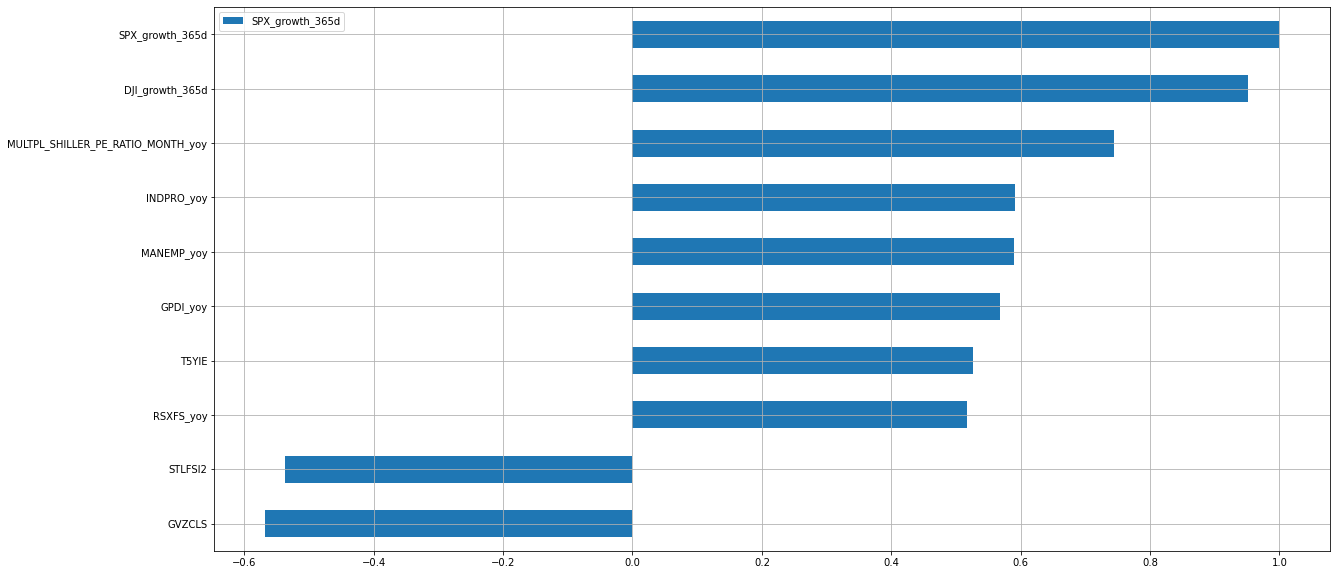

In [89]:
filter = np.abs(SPX_growth_365d_corr.SPX_growth_365d)>=0.5
SPX_growth_365d_corr[filter].plot.barh(figsize=(20,10), grid=True)

In [90]:
macro_df.corr()['SPX_growth_365d'].sort_values()

GVZCLS                              -0.568118
STLFSI2                             -0.536799
VIXCLS                              -0.403781
FODSP                               -0.367404
M1V                                 -0.342645
                                       ...   
MANEMP_yoy                           0.589725
INDPRO_yoy                           0.591908
MULTPL_SHILLER_PE_RATIO_MONTH_yoy    0.744727
DJI_growth_365d                      0.952057
SPX_growth_365d                      1.000000
Name: SPX_growth_365d, Length: 166, dtype: float64

In [91]:
macro_df.corr()['DJI_growth_365d'].sort_values()

GVZCLS                              -0.615214
STLFSI2                             -0.528316
VIXCLS                              -0.441840
GFDEGDQ188S_yoy                     -0.370017
UNEMPLOY_yoy                        -0.369028
                                       ...   
MANEMP_yoy                           0.581266
INDPRO_yoy                           0.623204
MULTPL_SHILLER_PE_RATIO_MONTH_yoy    0.702960
SPX_growth_365d                      0.952057
DJI_growth_365d                      1.000000
Name: DJI_growth_365d, Length: 166, dtype: float64

In [92]:
macro_df.corr()['SPX_growth_90d'].sort_values()

STLFSI2                             -0.587925
VIXCLS                              -0.530283
GVZCLS                              -0.529760
TEDRATE                             -0.326691
WALCL_mom                           -0.307482
                                       ...   
DJI_growth_30d                       0.514375
MULTPL_SHILLER_PE_RATIO_MONTH_mom    0.530288
SPX_growth_30d                       0.546847
DJI_growth_90d                       0.947767
SPX_growth_90d                       1.000000
Name: SPX_growth_90d, Length: 166, dtype: float64

In [93]:
macro_df.corr()['SPX_growth_30d'].sort_values()

VIXCLS           -0.451380
STLFSI2          -0.409452
GVZCLS           -0.398400
WALCL_mom        -0.304194
WALCL_wow        -0.252969
                    ...   
SPX_growth_7d     0.447537
DJI_growth_90d    0.503858
SPX_growth_90d    0.546847
DJI_growth_30d    0.954103
SPX_growth_30d    1.000000
Name: SPX_growth_30d, Length: 166, dtype: float64

In [94]:
# Future growth indicators are mostly correlated with each other
future_ind = []
for ind in macro_df.keys():
  if 'future' in ind:
    future_ind.append(ind)
  
print(future_ind)

['SPX_future_growth_1d', 'SPX_future_growth_3d', 'SPX_future_growth_7d', 'SPX_future_growth_30d', 'SPX_future_growth_90d', 'SPX_future_growth_365d', 'DJI_future_growth_1d', 'DJI_future_growth_3d', 'DJI_future_growth_7d', 'DJI_future_growth_30d', 'DJI_future_growth_90d', 'DJI_future_growth_365d']


In [95]:
# include all features 
macro_df_no_future_ind = macro_df.keys()
# do not use future_ind in the list to find correlations with the label (which is a future_indicator)
macro_df_no_future_ind = macro_df_no_future_ind.drop(future_ind)

In [96]:
macro_df.corr()['SPX_future_growth_365d'][macro_df_no_future_ind].sort_values()

T10YIE                   -0.462141
M1V                      -0.449105
T5YIE                    -0.448687
T5YIFR                   -0.370057
DCOILWTICO_growth_365d   -0.326696
                            ...   
UNRATE                    0.246755
GVZCLS                    0.251811
DTWEXAFEGS                0.326609
PSAVERT                   0.388430
DTWEXBGS                  0.395533
Name: SPX_future_growth_365d, Length: 154, dtype: float64

In [97]:
macro_df.corr()['SPX_future_growth_90d'][macro_df_no_future_ind].sort_values()

T10YIE            -0.246288
T5YIFR            -0.232812
M1V               -0.216889
T5YIE             -0.212442
FODSP             -0.188924
                     ...   
DTWEXAFEGS         0.185877
GFDEGDQ188S_yoy    0.198197
GFDEBTN_yoy        0.208674
PSAVERT            0.221006
DTWEXBGS           0.229958
Name: SPX_future_growth_90d, Length: 154, dtype: float64

In [98]:
macro_df.corr()['SPX_future_growth_30d'][macro_df_no_future_ind].sort_values()

BCHAIN_MKPRU_growth_90d   -0.119369
CPIAUCSL_yoy              -0.117467
M1V                       -0.114829
CDSP                      -0.109326
FODSP                     -0.105630
                             ...   
GFDEGDQ188S_yoy            0.109748
SPCS20RSA_mom              0.111574
GFDEBTN_yoy                0.119063
DTWEXBGS                   0.125778
PSAVERT                    0.142939
Name: SPX_future_growth_30d, Length: 154, dtype: float64

# 5) Decision Tree for Features Importance

In [99]:
# all features should be numeric
for key in macro_df.keys():
  macro_df[key] = macro_df[key].astype(float)

In [100]:
# include all features 
X_keys = macro_df.keys()
# do not use future ind to predict
X_keys = X_keys.drop(future_ind)

In [101]:
# deep copy of the dataframe not to change the original df
macro_copy = macro_df.copy(deep=True)

In [102]:
# replace bad values with np.nan
macro_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

In [103]:
macro_copy.fillna(0,inplace=True)
# macro_copy.dropna(inplace=True)

In [104]:
macro_copy.shape

(8820, 166)

In [105]:
X = macro_copy[X_keys]

In [106]:
#get all features in X and dependent variable in y
y = macro_copy['SPX_future_growth_90d']

In [107]:
X.tail()

WM1NS_wow  WM1NS_mom  WM2NS_wow  WM2NS_mom  WALCL_wow  ...  \
2022-05-02   0.006863   0.016334   0.006691   0.016604  -0.001859  ...   
2022-05-03   0.006863   0.016334   0.006691   0.016604  -0.001859  ...   
2022-05-04   0.006863   0.016334   0.006691   0.016604   0.000086  ...   
2022-05-05   0.006863   0.016334   0.006691   0.016604   0.000086  ...   
2022-05-06   0.006863   0.016334   0.006691   0.016604   0.000086  ...   

            SPCS20RSA_mom  SPCS20RSA_yoy  MULTPL_SHILLER_PE_RATIO_MONTH  \
2022-05-02       0.017085        0.18934                          36.71   
2022-05-03       0.017085        0.18934                          36.71   
2022-05-04       0.017085        0.18934                          36.71   
2022-05-05       0.017085        0.18934                          36.71   
2022-05-06       0.017085        0.18934                          36.71   

            MULTPL_SHILLER_PE_RATIO_MONTH_mom  \
2022-05-02                           0.060676   
2022-05-03                           0.060676   
2022-05-04                           0.060676   
2022-05-05                           0.060676   
2022-05-06                           0.060676   

            MULTPL_SHILLER_PE_RATIO_MONTH_yoy  
2022-05-02                          -0.024189  
2022-05-03                          -0.024189  
2022-05-04                          -0.024189  
2022-05-05                          -0.024189  
2022-05-06                          -0.024189  

[5 rows x 154 columns]

In [108]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/

from collections import OrderedDict
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

In [109]:
# define a function that returns an ordered dictionary of features, sorted by importance
def get_importance_features(model):
  importance = model.feature_importances_
  feat_imp = OrderedDict()
  # summarize feature importance
  for i,v in enumerate(importance):
    feat_imp[X.keys()[i]] = importance[i]

  # https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value  
  sorted_feat_imp = sorted(feat_imp.items(), key=lambda kv: kv[1])

  return sorted_feat_imp

In [110]:
# init the class and fit the model
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X, y)

decision_feat_imp = get_importance_features(decision_tree_model)

In [111]:
# Prediction of SPX_future_growth_90d:
decision_feat_imp[-10:]

[('SPX', 0.028594056106415827),
 ('DJI', 0.0288738252168991),
 ('TCU', 0.0401173295243026),
 ('PSAVERT_yoy', 0.04290286953694531),
 ('GDPDEF_qoq', 0.043493503928064774),
 ('CIVPART_yoy', 0.04872202018674545),
 ('GFDEGDQ188S', 0.0784134978971972),
 ('VIXCLS', 0.0815562961779623),
 ('MULTPL_SHILLER_PE_RATIO_MONTH', 0.11184816108376688),
 ('M1V', 0.1357426752877918)]

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [113]:
# define the model
decision_tree_model2 = DecisionTreeRegressor()
decision_tree_model2.fit(X_train, y_train)

decision_feat_imp2 = get_importance_features(decision_tree_model2)

In [114]:
decision_feat_imp2[-10:]

[('M2V_qoq', 0.018037035284460854),
 ('DJI', 0.036005253048368366),
 ('GDPDEF_qoq', 0.050879777405216646),
 ('TCU', 0.05092657038806961),
 ('CIVPART_yoy', 0.05761808320578606),
 ('CP_qoq', 0.057921200339033),
 ('VIXCLS', 0.07305007432704609),
 ('GFDEGDQ188S', 0.0839159093310087),
 ('MULTPL_SHILLER_PE_RATIO_MONTH', 0.13158542928807115),
 ('M1V', 0.1548998646592987)]

In [115]:
y_pred = decision_tree_model2.predict(X_test)

In [116]:
# https://stackabuse.com/decision-trees-in-python-with-scikit-learn/
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df[0:10]

Actual  Predicted
2015-05-07 -0.057081  -0.076709
2015-05-08 -0.054685  -0.076709
2015-05-11 -0.067214  -0.038458
2015-05-12 -0.062669  -0.038458
2015-05-13 -0.084088  -0.038458
2015-05-14 -0.086667  -0.058871
2015-05-15 -0.092504  -0.038458
2015-05-18 -0.092343  -0.038458
2015-05-19 -0.114815  -0.038458
2015-05-20 -0.115791  -0.038458

In [117]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=8, random_state=0)

In [118]:
clf.fit(X_train, y_train)

clf_imp = get_importance_features(clf)

In [119]:
y_pred_clf = clf.predict(X_test)

In [120]:
df2 = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred_clf})

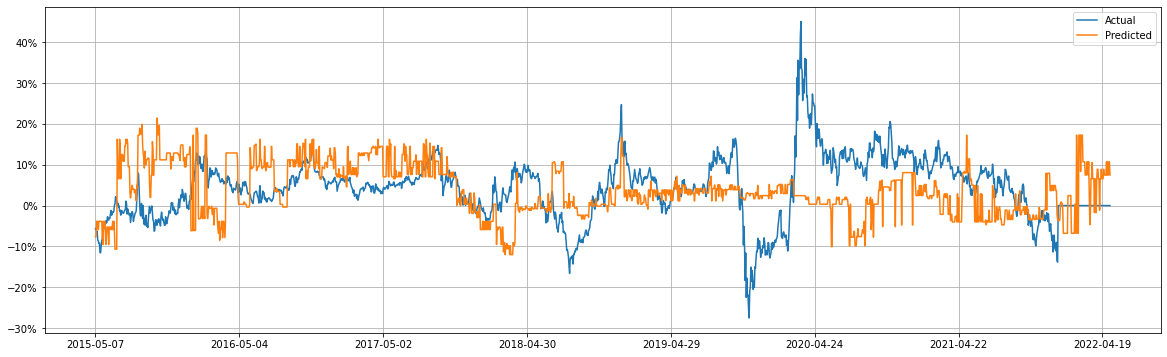

In [121]:
# Decision Tree : Actual vs. Predicted graph
import matplotlib.ticker as mtick

ax = df.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


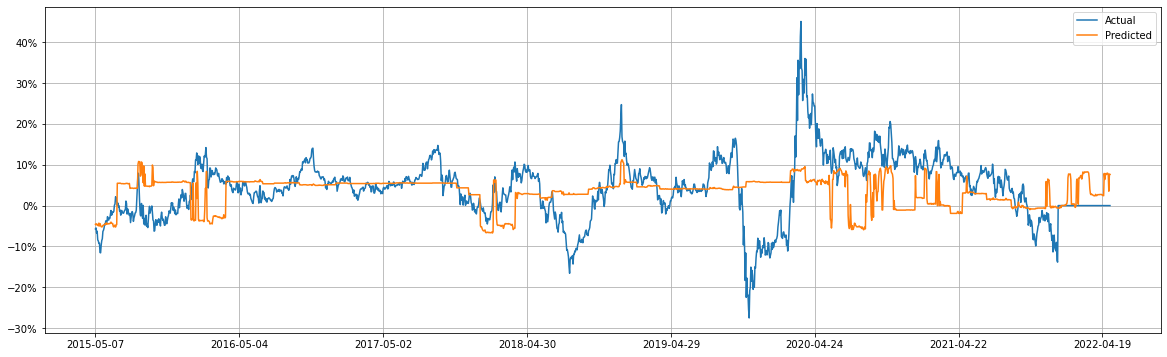

In [122]:
# Random Forest regressor : Actual vs. Predicted graph

import matplotlib.ticker as mtick

ax = df2.plot(figsize=(20,6), grid=True)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SPX_future_growth_90d', ylabel='Density'>

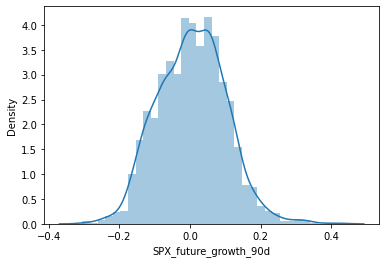

In [123]:
# what is the distribution of errors?
import seaborn as sns
sns.distplot(y_test-y_pred)

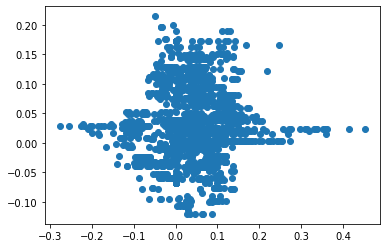

In [124]:
plt.scatter(y_test,y_pred)

In [125]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.07732845566956736
Mean Squared Error: 0.009318265098174463
Root Mean Squared Error: 0.09653116128056506


In [126]:
# GridSearch for Hyperparams: https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
# parameters={"splitter":["best","random"],
#             "max_depth" : [1,3,5,7],
#            "min_samples_leaf":[1,2,3,4],
#            "min_weight_fraction_leaf":[0.1,0.2,0.3],
#            "max_features":["auto","log2","sqrt",None],
#            "max_leaf_nodes":[None,10,20,30] }

In [127]:
from sklearn.model_selection import GridSearchCV

tuning_model = GridSearchCV(decision_tree_model, 
                            param_grid=parameters, 
                            scoring='neg_mean_squared_error',
                            cv=3,
                            verbose=3,
                            n_jobs = -1)
# https://stackoverflow.com/questions/18752795/gridsearchcv-n-jobs-in-parallel-internals

In [128]:

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

In [129]:
%%capture
from datetime import datetime

start_time=timer(None)

tuning_model.fit(X,y)

timer(start_time)

In [130]:
tuning_model.best_params_


{'max_depth': 12,
 'max_features': 'log2',
 'max_leaf_nodes': 50,
 'min_samples_leaf': 9,
 'min_weight_fraction_leaf': 0.2,
 'splitter': 'best'}

In [131]:
tuned_hyper_model= DecisionTreeRegressor(max_depth=12,
                                         max_features='sqrt',
                                         max_leaf_nodes=70,
                                         min_samples_leaf=1,
                                         min_weight_fraction_leaf=0.1,
                                         splitter='random')

In [132]:
tuned_hyper_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=12, max_features='sqrt', max_leaf_nodes=70,
                      min_weight_fraction_leaf=0.1, splitter='random')

In [133]:
tuned_pred = tuned_hyper_model.predict(X_test)

In [134]:
df3 = pd.DataFrame({'Actual': y_test, 'Predicted':tuned_pred})

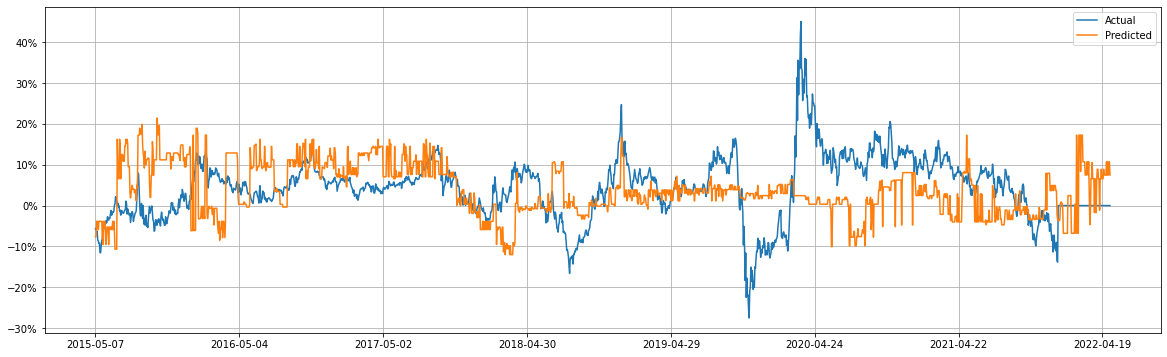

In [135]:
ax = df.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


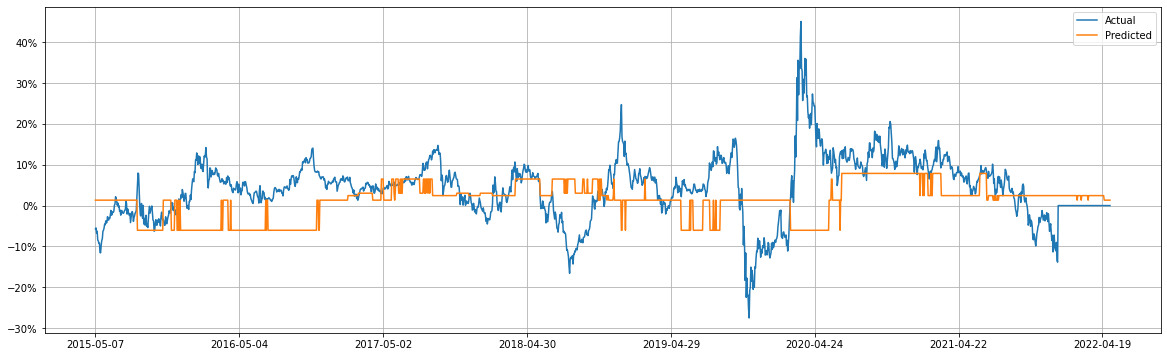

In [136]:
ax = df3.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
